In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import hydra
import torch
from omegaconf import DictConfig, OmegaConf

from sklearn.manifold import TSNE # new
from sklearn.decomposition import PCA
import seaborn as sns

from lightning.pytorch import (
    seed_everything,
)

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.loader import BiTemporalDataset
from src.data.process import generate_grid_prompt, DefaultTransform
from src.models.magic_pen.task import MagicPenModule
from src.models.segment_any_change.model import BiSam
from src.models.segment_any_change.mask_generator import SegAnyMaskGenerator
from src.models.commons.mask_items import ImgType


In [2]:
from torch.nn.utils.rnn import pad_sequence
from src.models.commons.mask_process import extract_object_from_batch

In [3]:
def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(
        config_name="eval", 
        overrides=["experiment=seganychange_matching", 
                   "sam_type=small", 
                   "data=levir-cd",
                  ])
    
    return cfg
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
cfg = load_config()

In [4]:
cfg.sam_enc_arch

'vit-b'

In [5]:
seed_everything(seed=cfg.seed)


Seed set to 12


12

In [6]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":3,
    "loc": "center",
    "batch_size": 2,
}


sam_kwargs = {
    "sam_ckpt_path":'/var/data/usr/mdizier/stylo_magique/checkpoints/sam/sam_vit_b_01ec64.pth',
    'pred_iou_thresh': 0.8,
     'stability_score_thresh': 0.8,
     'stability_score_offset': 1.0,
     'box_nms_thresh': 0.7,
     'min_mask_region_area': 0,
     'mask_threshold': 0
}

indices = [12, 13]

# ds = BiTemporalDataset(
#             name="levir-cd",
#             dtype="test",
#             transform=DefaultTransform(),
#             params=OmegaConf.create(params),
#         )

# subset = torch.utils.data.Subset(ds, indices)

# dloader = data.DataLoader(
#             subset,
#             batch_size=params.get('batch_size'),
#             shuffle=False,
#             num_workers=0,
#         )

def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

In [7]:
data_module = hydra.utils.instantiate(cfg.data)
dloader = get_dloader("test", data_module)

In [8]:
batch = next(iter(dloader))

In [19]:
idx = 12
for i, batch in enumerate(dloader):
    if i == idx:
        break

In [9]:
batch["point_coords"].shape

torch.Size([2, 1024, 2])

In [10]:
# seganychange model
sam_arch = cfg.sam_enc_arch.replace("-", "_")
bisam = load_sam(
    model_type=sam_arch, model_cls=BiSam, version= "dev", device="cpu"
)

2024-08-23 17:27:03,051 - INFO ::  build vit_b BiSam


INIT VIT


In [11]:
# seganychange model - matching
mask_generator = SegAnyMaskGenerator(
    model=bisam,
    **sam_kwargs
)

In [12]:
img_anns = mask_generator.generate(batch)

sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
OUT MODEL : torch.Size([4, 1024, 3, 256, 256])
ATTACH 179 masks
ATTACH 228 masks
ATTACH 189 masks
ATTACH 253 masks


In [13]:
img_anns[0].keys()

dict_keys(['masks', 'masks_logits', 'bbox', 'predicted_iou', 'img_type'])

In [14]:
img_anns[1]["masks"].shape

torch.Size([228, 256, 256])

In [15]:
img_anns[3]["masks"].shape

torch.Size([253, 256, 256])

In [16]:
mask_batch = pad_sequence([m["masks"] for m in img_anns if m["img_type"] == ImgType.B], batch_first=True)
label_batch = extract_object_from_batch(batch["label"])

In [17]:
label_batch.shape

torch.Size([2, 60, 1024, 1024])

### Remove labels object from batch

On souhaite extraire les objets qui ne sont pas des batiments. On fait l'approximation que les batiments de changement ~ batiments. On filtrera si necessaire

In [18]:
backgrd_obj_batch = []
rejected_obj_batch = []
mask_batch_ = resize(mask_batch, label_batch.shape[-2:])
for i, item in enumerate(mask_batch_):
    label_i = torch.sum(label_batch[i], dim=0)
    backgrd_obj = []
    rejected_obj = []
    for mask in mask_batch_[i]:
        if not torch.sum((torch.logical_and(mask, label_i))):
            backgrd_obj.append(mask)
        else:
            rejected_obj.append(mask)
    
    backgrd_obj_batch.append(torch.stack(backgrd_obj) if backgrd_obj else torch.zeros(1, 1024, 1024))
    rejected_obj_batch.append(torch.stack(rejected_obj) if rejected_obj else torch.zeros(1, 1024, 1024))

backgrd_obj_batch = pad_sequence(backgrd_obj_batch, batch_first=True)
rejected_obj_batch = pad_sequence(rejected_obj_batch, batch_first=True)

In [19]:
rejected_obj_batch.shape

torch.Size([2, 90, 1024, 1024])

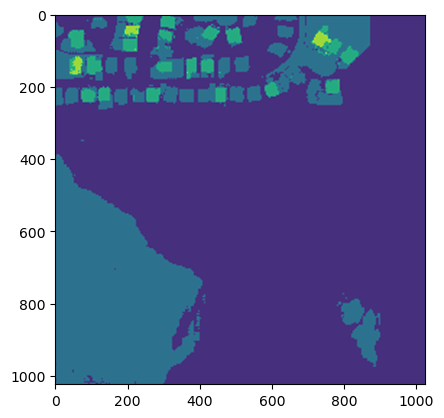

In [20]:
plt.imshow(torch.sum(rejected_obj_batch[1], dim=0))

Il peut y avoir de l'overlap dans les masques background...

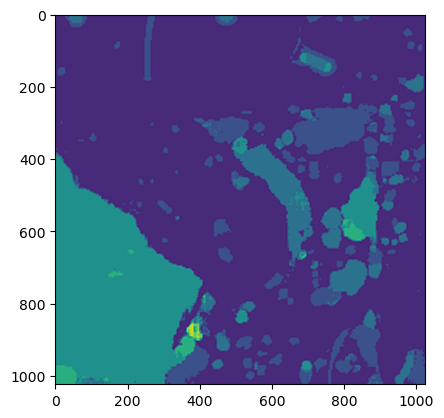

In [21]:
plt.imshow(torch.sum(backgrd_obj_batch[1], dim=0))

In [22]:
label_batch.shape

torch.Size([2, 60, 1024, 1024])

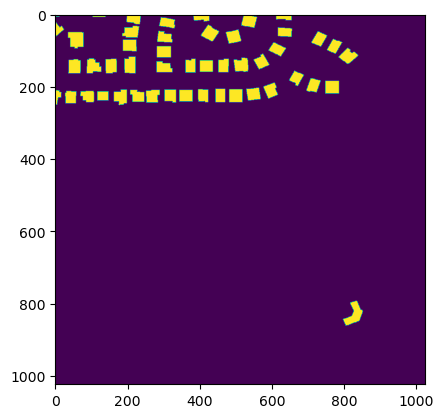

In [23]:
plt.imshow(batch["label"][1])

In [24]:
backgrd_obj_batch.shape

torch.Size([2, 232, 1024, 1024])

In [25]:
from models.segment_any_change.embedding import (
    _compute_mask_embedding_batch_torch,
_compute_mask_embedding_torch,
    get_img_embedding_normed,
)

imgs_embedding = get_img_embedding_normed(
    mask_generator.model, ImgType.B
)

In [26]:
imgs_embedding.shape

torch.Size([2, 256, 64, 64])

#### Compute mask embeddings

In [27]:
# memory compute
backgrd_obj_batch = resize(backgrd_obj_batch, (256, 256))
label_batch = resize(label_batch, (256, 256))

In [28]:
label_batch.shape

torch.Size([2, 60, 256, 256])

In [29]:
label_embedding = _compute_mask_embedding_batch_torch(label_batch, imgs_embedding)

In [30]:
backgrd_obj_embedding = _compute_mask_embedding_batch_torch(backgrd_obj_batch, imgs_embedding)

In [31]:
backgrd_obj_embedding.shape

torch.Size([2, 232, 256])

#### Visualisation

In [32]:
idx = 1
back_emb = backgrd_obj_embedding[idx]
label_emb = label_embedding[idx]

In [33]:
back_emb = pd.DataFrame(back_emb)
label_emb = pd.DataFrame(label_emb)
back_emb["label"] = 0
label_emb["label"] = 1

In [34]:
tsne = TSNE(n_components=2, perplexity=5)

In [35]:
data = pd.concat([back_emb.dropna(), label_emb.dropna()])#.sample(frac=1)

In [36]:
data.shape

(211, 257)

In [37]:
out = tsne.fit_transform(data.drop("label", axis=1))

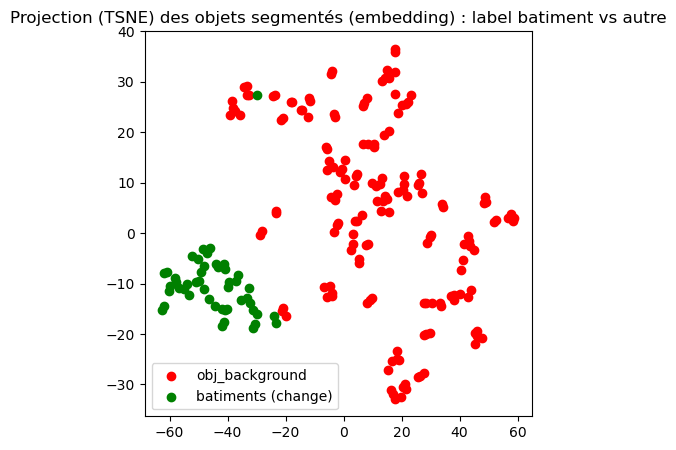

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))

red = data["label"] == 0
green = data["label"] == 1

ax.scatter(out[red, 0], out[red, 1], c="r", label="obj_background")
ax.scatter(out[green, 0], out[green, 1], c="g", label="batiments (change)")
ax.set_title("Projection (TSNE) des objets segmentés (embedding) : label batiment vs autre")
plt.legend()

Les points non-batiments proche du cluster batiments sont il des batiments de non-changements ?

In [39]:
pca = PCA(n_components=2)

In [40]:
out = pca.fit_transform(data.drop("label", axis=1))

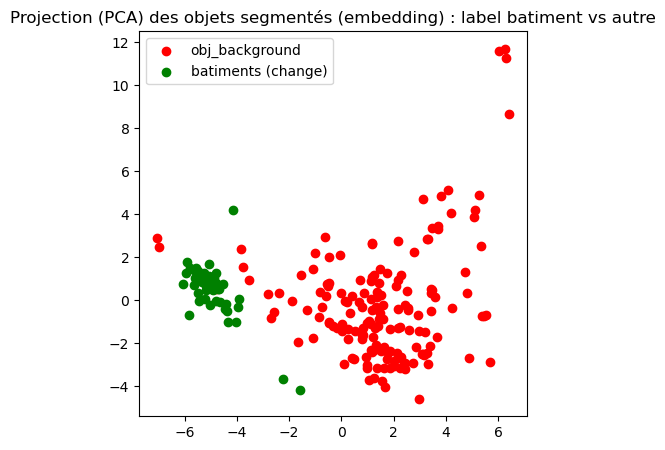

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))

red = data["label"] == 0
green = data["label"] == 1

ax.scatter(out[red, 0], out[red, 1], c="r", label="obj_background")
ax.scatter(out[green, 0], out[green, 1], c="g", label="batiments (change)")
ax.set_title("Projection (PCA) des objets segmentés (embedding) : label batiment vs autre")
plt.legend()

### Clustering

Essayons de voir quels sont les objets similaires aux batîments de changement

In [43]:
from sklearn.cluster import KMeans

In [46]:
X = data.drop("label", axis=1)
y = data["label"]

In [47]:
kmeans = KMeans(n_clusters=2, random_state=12)

In [48]:
pred = kmeans.fit_transform(X)

In [50]:
pred = kmeans.fit_predict(X)

In [55]:
df = data.copy()
pred = np.where(pred == 1, 0, 1) # reverse labels
df["pred_clst"] = pred

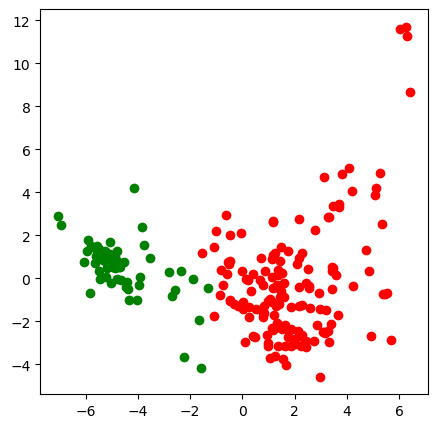

In [58]:
fig, ax = plt.subplots(figsize=(5, 5))

red = df["pred_clst"] == 0
green = df["pred_clst"] == 1

ax.scatter(out[red, 0], out[red, 1], c="r", label="obj_background")
ax.scatter(out[green, 0], out[green, 1], c="g", label="batiments (change)")

Quels sont les samples qui ont le label 0 (background) mais appartiennent au cluster 1; i.e les objet du background similaire aux batiments ?

In [62]:
df[(df["label"] == 0) & (df["pred_clst"] == 1)]

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,label,pred_clst
4,0.020444,-0.057711,-0.392408,0.183772,-0.116307,-0.117062,0.171741,-0.020860,0.804301,-0.419915,...,-0.108555,1.062442,0.016419,-0.121015,-1.419880,-0.645194,0.020115,-0.023499,0,1
5,0.344626,-0.397760,-0.739019,-0.039476,-0.425332,-0.077360,0.285696,0.080603,1.025801,-0.585591,...,-0.252149,1.169941,0.083853,-0.168860,-1.721036,-0.740036,0.107451,-0.078970,0,1
6,0.075717,-0.256316,-0.623173,-0.012077,0.116349,-0.086244,0.083454,-0.138871,0.883798,-0.478355,...,-0.126638,1.309804,0.067938,-0.240743,-1.296434,-0.844769,-0.094879,0.220803,0,1
12,-0.356130,-0.570531,-0.261087,-0.110733,0.300100,-0.052586,-0.125076,0.339941,0.721186,0.429113,...,-0.269064,0.654184,0.078246,-0.449005,-0.214788,-0.182123,0.126409,0.132913,0,1
33,-0.026888,-0.257552,-0.405935,-0.329772,-0.364716,0.606393,0.644915,0.351453,1.499334,-0.349617,...,0.386543,1.518994,0.381980,-0.188381,-0.232026,0.694993,-1.090468,-0.174765,0,1
42,0.323882,-0.442016,-0.782665,-0.214030,-0.260128,-0.113890,0.212453,-0.007930,1.134321,-0.718911,...,-0.256616,1.347187,0.131260,-0.256376,-1.533126,-0.908970,-0.005793,0.434434,0,1
62,-0.159876,-0.317828,-0.142337,0.113548,-0.007168,0.193477,0.493156,0.099450,0.719474,-0.212389,...,0.177654,1.328042,0.091421,-0.129980,-0.667884,0.552922,-0.376334,-0.058970,0,1
66,-0.740717,-0.154462,-0.326863,0.430976,0.229269,-0.275213,-0.153940,-0.083680,0.418718,0.271984,...,-0.439349,1.175698,-0.190694,-0.186706,-0.198864,-0.045728,-0.206445,-0.088276,0,1
108,-0.432837,-0.703956,-0.227649,0.572966,0.277462,0.830048,0.275889,0.095664,0.452126,-0.067974,...,-0.081592,1.574164,0.642848,-0.339190,-0.938274,0.869282,-0.157349,-0.132993,0,1
113,0.161854,-0.179017,0.269403,-0.113937,-0.032384,0.433155,0.527409,-0.239182,0.231316,-0.308066,...,0.263218,2.000965,0.143154,-0.037711,-1.258043,0.844421,0.371109,0.507175,0,1


In [63]:
indices = list(df[(df["label"] == 0) & (df["pred_clst"] == 1)].index)

In [65]:
sim_back_obj = backgrd_obj_batch[idx][indices, :]

In [66]:
sim_back_obj.shape

torch.Size([14, 256, 256])

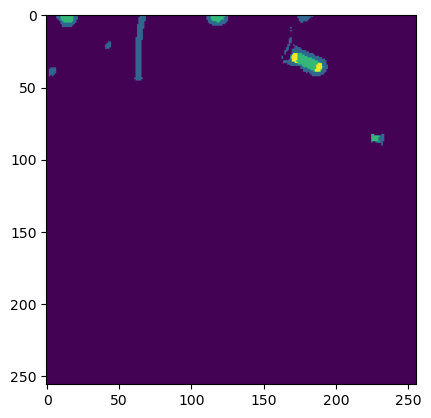

In [68]:
plt.imshow(torch.sum(sim_back_obj, axis=0))

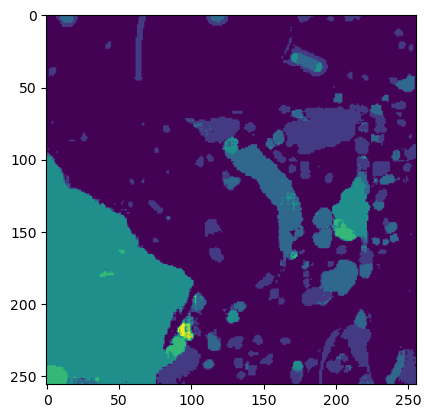

In [70]:
plt.imshow(torch.sum(backgrd_obj_batch[idx], axis=0))

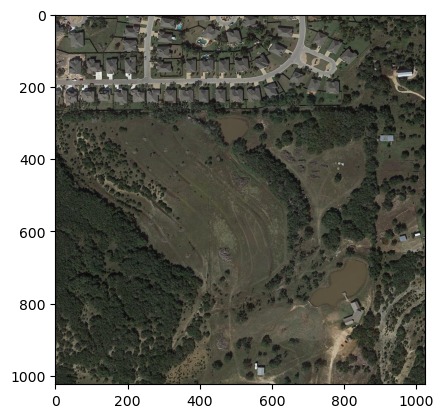

In [248]:
idx = 1
plt.imshow(batch["img_B"][idx].permute(1, 2, 0)/255)

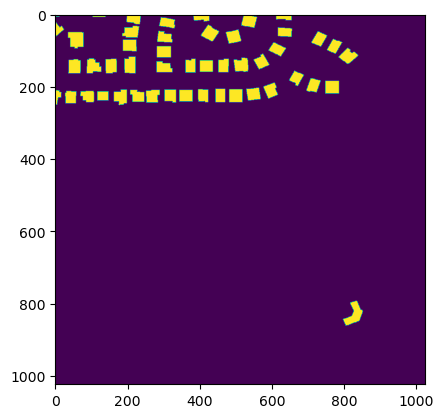

In [249]:
plt.imshow(batch["label"][idx])

In [ ]:
imgs_embedding_B = get_img_embedding_normed(
    mask_generator.model, ImgType.B
)

In [1]:
4057 + 1099

5156